In [1]:
#!pip install -q --upgrade keras-nlp tensorflow

In [6]:
import os

import keras_nlp
import tensorflow as tf
from tensorflow import keras

In [7]:
import matplotlib.pyplot as plt

# Initial Setup

In [8]:
# Performance Setting
# Enable mixed precision to speed up training by running computations with 16-bit (instead of 32-bit) floating point numbers

policy = keras.mixed_precision.Policy("mixed_float16")
keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2023-10-22 11:24:19.184729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 11:24:19.332958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 11:24:19.333043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
# Define hyperparameters used during training
# Prep: Preprocessing params.
PRETRAINING_BATCH_SIZE = 128
FINETUNING_BATCH_SIZE = 32

# Pretraining
    # Tokenizer:
SEQ_LENGTH = 128

    # Masker:
MASK_RATE = 0.25
PREDICTIONS_PER_SEQ = 32

# Create the transformer encoder
MODEL_DIM = 256
NORM_EPSILON = 1e-5
DROPOUT = 0.1
INTERMEDIATE_DIM = 512
NUM_LAYERS = 3
NUM_HEADS = 4

# Pretrain the transformer
PRETRAINING_LEARNING_RATE = 5e-4
PRETRAINING_EPOCHS = 8

#Fine Tune the transformer
FINETUNING_LEARNING_RATE = 5e-5
FINETUNING_EPOCHS = 3

In [10]:
# Download the following datasets:
# WikiText-103: A medium sized collection of featured articles from English Wikipedia, which we will use for pretraining.
keras.utils.get_file(origin="https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip",extract=True,)
wiki_dir = os.path.expanduser("~/.keras/datasets/wikitext-103-raw/")

# A WordPiece vocabulary -- Will be used for tokenization below
vocab_file = keras.utils.get_file(origin="https://storage.googleapis.com/tensorflow/keras-nlp/examples/bert/bert_vocab_uncased.txt",)

# SST-2 a text classification dataset and our "end goal". This dataset is often used to benchmark language models.
# This is the dataset that will be used for fine-tuning

keras.utils.get_file(origin="https://dl.fbaipublicfiles.com/glue/data/SST-2.zip", extract=True,)
sst_dir = os.path.expanduser("~/.keras/datasets/SST-2/")

In [11]:
# Load wikitext-103 and filter out short lines.
wiki_train_ds = (tf.data.TextLineDataset(
    wiki_dir + "wiki.train.raw").filter(lambda x: tf.strings.length(x) > 100).batch(PRETRAINING_BATCH_SIZE))

wiki_val_ds = (tf.data.TextLineDataset(
    wiki_dir + "wiki.valid.raw").filter(lambda x: tf.strings.length(x) > 100).batch(PRETRAINING_BATCH_SIZE))



2023-10-22 11:24:42.753014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 11:24:42.753108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 11:24:42.753198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# Load SST-2 and split into train and validation sets
sst_train_ds = tf.data.experimental.CsvDataset(sst_dir + "train.tsv", 
                                               [tf.string, tf.int32], 
                                               header=True, field_delim="\t").batch(FINETUNING_BATCH_SIZE)

sst_val_ds = tf.data.experimental.CsvDataset(sst_dir + "dev.tsv", 
                                             [tf.string, tf.int32], 
                                             header=True, field_delim="\t").batch(FINETUNING_BATCH_SIZE)

# Take a peak at the sst-2 dataset.
print(sst_train_ds.unbatch().batch(4).take(1).get_single_element())

(<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'hide new secretions from the parental units ',
       b'contains no wit , only labored gags ',
       b'that loves its characters and communicates something rather beautiful about human nature ',
       b'remains utterly satisfied to remain the same throughout '],
      dtype=object)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 0, 1, 0], dtype=int32)>)


## Baseline

In [13]:
# Train a simple bag-of-words model, where we learn a positive or negative weight for each word in our vocabulary. 
# A sample's score is simply the sum of the weights of all words that are present in the sample.


# This layer will turn our input sentence into a list of 1s and 0s the same size our vocabulary, indicating whether a word is
# present in absent.
multi_hot_layer = keras.layers.TextVectorization(max_tokens=4000, output_mode="multi_hot")
multi_hot_layer.adapt(sst_train_ds.map(lambda x, y: x))


# We then learn a linear regression over that layer, and that's our entire baseline model!
regression_layer = keras.layers.Dense(1, activation="sigmoid")

inputs = keras.Input(shape=(), dtype="string")
outputs = regression_layer(multi_hot_layer(inputs))

baseline_model = keras.Model(inputs, outputs)
baseline_model.compile(loss="binary_crossentropy", metrics=["accuracy"])
baseline_model.fit(sst_train_ds, validation_data=sst_val_ds, epochs=5)

# Accuracy = 81.15% 

Epoch 1/5


2023-10-22 11:24:44.180858: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17775536536356950441
2023-10-22 11:24:44.180879: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3170706517198437320
2023-10-22 11:24:44.180882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7217950443937707068
2023-10-22 11:24:45.411106: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f897f369540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 11:24:45.411119: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-22 11:24:45.461221: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


     47/Unknown - 2s 1ms/step - loss: 0.6918 - accuracy: 0.5146

2023-10-22 11:24:45.642875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 11:24:45.782144: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2105/2105 [==============================] - 4s 1ms/step - loss: 0.6130 - accuracy: 0.6856 - val_loss: 0.5350 - val_accuracy: 0.7580
Epoch 2/5
  50/2105 [..............................] - ETA: 2s - loss: 0.5581 - accuracy: 0.7250

2023-10-22 11:24:48.051418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5522529174608138253
2023-10-22 11:24:48.051434: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3339746861611884744
2023-10-22 11:24:48.051447: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2709090716529279401
2023-10-22 11:24:48.051451: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16177943926765088738
2023-10-22 11:24:48.051455: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18015752739085066033
2023-10-22 11:24:48.051458: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16775387188069078696
2023-10-22 11:24:48.051461: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv 

2105/2105 [==============================] - 2s 1ms/step - loss: 0.5249 - accuracy: 0.7598 - val_loss: 0.4869 - val_accuracy: 0.7878
Epoch 3/5
2105/2105 [==============================] - 2s 1ms/step - loss: 0.4786 - accuracy: 0.7873 - val_loss: 0.4664 - val_accuracy: 0.7982
Epoch 4/5
2105/2105 [==============================] - 2s 1ms/step - loss: 0.4486 - accuracy: 0.8020 - val_loss: 0.4575 - val_accuracy: 0.8028
Epoch 5/5
2105/2105 [==============================] - 2s 1ms/step - loss: 0.4272 - accuracy: 0.8118 - val_loss: 0.4545 - val_accuracy: 0.8028


A bag-of-words approach can be a fast and surprisingly powerful, especially when input examples contain a large number of
words.  With shorter sequences, it can hit a performance ceiling.

To do better, we would like to build a model that can evaluate words in context. Instead of evaluating each word in a void, 
we need to use the information contained in the entire ordered sequence of our input.

This runs us into a problem. SST-2 is very small dataset, and there's simply not enough example text to attempt to build a 
larger, more parameterized model that can learn on a sequence. We would quickly start to overfit and memorize our training set,
without any increase in our ability to generalize to unseen examples.

Enter pretraining, which will allow us to learn on a larger corpus, and transfer our knowledge to the SST-2 task. 
And enter KerasNLP, which will allow us to pretrain a particularly powerful model, the Transformer, with ease.

# Pretraining

We are going to train a transformer, a highly expressive model which will learn to embed each word in our input as a low dimentional vector. Our wikipedia dataset has no labels, so we will use an unsupervised training objective called the Masked Language Modeling (MaskedLM) objective.

Essentially, we will be playing a big game of "guess the missing word". For each input sample we will obscure 25% of our input data, and train our model to predict the parts we covered up.

## Preprocess Data for the MaskedLM task

In [14]:
# Check the first record of the Wiki training dataset
print(wiki_train_ds.unbatch().batch(1).take(1).get_single_element())

tf.Tensor([b' Senj\xc5\x8d no Valkyria 3 : Unrecorded Chronicles ( Japanese : \xe6\x88\xa6\xe5\xa0\xb4\xe3\x81\xae\xe3\x83\xb4\xe3\x82\xa1\xe3\x83\xab\xe3\x82\xad\xe3\x83\xa5\xe3\x83\xaa\xe3\x82\xa23 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . '], shape=(1,), dtype=string)


In [15]:
# These tokenizers convert strings to tensors of token ids.  The raw bytes of a string are too high dimensional to be useful
# features so we first map them to a small number of tokens, 
# Example: "The quick brown fox" to ["the", "qu", "##ick", "br", "##own", "fox"]

# WordPieceTokenizer does sub-word tokenization.  It allows our model to learn from uncommon words, while not requiring a
# massive vocabulary of every work in our training set.

# Setting sequence_length will trim or pad the token outputs to shape (batch_size, SEQ_LENGTH).

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(vocabulary=vocab_file,
                                                    sequence_length=SEQ_LENGTH,
                                                    lowercase=True,
                                                    strip_accents=True,)

In [16]:
# Mask certain positions in our input to predict on.  It will randomly select a set of tokens in each input and mask them out.

# Setting mask_selection_length will trim or pad the mask outputs to shape (batch_size, PREDICTIONS_PER_SEQ).
masker = keras_nlp.layers.MaskedLMMaskGenerator(vocabulary_size=tokenizer.vocabulary_size(),
                                                mask_selection_rate=MASK_RATE,
                                                mask_selection_length=PREDICTIONS_PER_SEQ,
                                                mask_token_id=tokenizer.token_to_id("[MASK]"),)


# Because our masking layer will choose new words to mask each time, each epoch over our dataset will give us a totally new set
# of labels to train on.

In [17]:
# The preprocessor converts strings to a dictionary of preprocessed tensors, starting with tokenization.  
# Each model uses special tokens and extra tensors to understand the inputs such as delimining input segments and
# identifying padding tokens.  Padding each sequence to the same legnth improves computational efficiency.

# The output of the preprocessor is fed to the "backbone" that converts these tensors to dense features.  
# The backbone cannot handle strings which is why the preprocessor step must be done first.
# It distills the input tokens into dense features that can be used in downstream tasks.  It is generally pretrained
# on a language modeling task using massive amounts of unlabeled data. 
# Transferring this information to a new task is a major breakthrough in modern NLP.
# Task models combine string preprocessing and the backbone model with task-specific Layers to solve a problem such as
# sentence classification, token classification, or text generation. The additional Layers must be fine-tuned on labeled data.

def preprocess(inputs):
    inputs = tokenizer(inputs)
    outputs = masker(inputs)
    
    # Split the masking layer outputs into a (features, labels, and weights) tuple that we can use with keras.Model.fit().
    
    # 2 Features: 
    #   - "token_ids": where some tokens have been replaced with our mask token id
    #   - "mask_positions": which tokens were masked out
    features = {"token_ids": outputs["token_ids"],
                "mask_positions": outputs["mask_positions"],
                   }
    #  labels are the ids we masked out
    labels = outputs["mask_ids"]
    
    # weights: Because not all sequences will have the same number of masks, we also keep a sample_weight tensor, 
    # which removes padded labels from our loss function by giving them zero weight
    weights = outputs["mask_weights"]
    
    return features, labels, weights

#### Added labels to identify what is what in the tuple so it is easier to understand the steps that shows a sample of it

In [18]:
# We use prefetch() to pre-compute preprocessed batches on the fly on the CPU.
pretrain_ds = wiki_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
pretrain_val_ds = wiki_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


In [19]:
# Preview a single input example. The masks will change each time you run the cell.
print(pretrain_val_ds.take(1).get_single_element())

({'token_ids': <tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[7570,  103, 2271, ..., 9673,  103, 7570],
       [ 103, 7849,  103, ..., 1007,  103, 2023],
       [ 103, 2034, 3940, ...,    0,    0,    0],
       ...,
       [2076, 1996, 2307, ...,    0,    0,    0],
       [3216, 2225, 2083, ...,    0,    0,    0],
       [9794, 2007, 1045, ...,    0,    0,    0]], dtype=int32)>, 'mask_positions': <tf.Tensor: shape=(128, 32), dtype=int64, numpy=
array([[  1,   4,   6, ..., 123, 124, 126],
       [  0,   2,   3, ..., 118, 123, 126],
       [  0,   6,   7, ...,   0,   0,   0],
       ...,
       [  3,   6,   7, ..., 106, 109,   0],
       [ 12,  14,  16, ...,   0,   0,   0],
       [  3,   5,  14, ...,   0,   0,   0]])>}, <tf.Tensor: shape=(128, 32), dtype=int32, numpy=
array([[ 7849,  7946,  2124, ..., 24000, 25009,  1012],
       [ 7570,  2271, 13091, ..., 14925, 11314,  1012],
       [ 1996, 22925,  2003, ...,     0,     0,     0],
       ...,
       [ 6245,  1997,  1996, ..

## Create the Transformer Encoder

In [20]:
inputs = keras.Input(shape=(SEQ_LENGTH,), dtype=tf.int32)

In [21]:
# Embed our tokens with a positional embedding.

# This layer sums a token and a position embedding.  This is a way of representing words and their order in a sequence.
# This layer creates token (using keras.layers.Embedding) and position (using keras_nlp.layers.PositionEmbedding) embeddings 
# and sums their output when called.  This layer assumes the last dimension in the input corresponds to the sequence dimension

# This layer simultaneously learns two embeddings -- one for words in a sentence and another for integer positions in a sentence. 

embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size=tokenizer.vocabulary_size(),
                                                             sequence_length=SEQ_LENGTH,
                                                             embedding_dim=MODEL_DIM,)



In [22]:
outputs = embedding_layer(inputs)

In [23]:
# Apply a normalization layer after the embedding layer set above
outputs = keras.layers.LayerNormalization(epsilon=NORM_EPSILON)(outputs)

In [24]:
# Apply a dropout layer after the normalization layer
outputs = keras.layers.Dropout(rate=DROPOUT)(outputs)

In [25]:
# Apply a series of transformer encoder layers on top of the normalization layer.  This is the core of the transformer model.
# It uses an attention mechanism to attend to different parts of the input sentence.  
# It is then followed by a multi-layer perceptron block.

for i in range(NUM_LAYERS):
    outputs = keras_nlp.layers.TransformerEncoder(intermediate_dim=INTERMEDIATE_DIM,
                                                  num_heads=NUM_HEADS,  # Controls how many parallel 
                                                  dropout=DROPOUT,
                                                  layer_norm_epsilon=NORM_EPSILON,)(outputs)
    
# num_head: the Attention module repeats its computations multiple times in parallel. Each of these is called an Attention Head.
# The Attention module splits its Query, Key, and Value parameters N-ways and passes each split independently through a separate 
# Head. All of these similar Attention calculations are then combined together to produce a final Attention score.
# https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853

In [26]:
encoder_model = keras.Model(inputs, outputs)
encoder_model.summary()

# The parameters here are mostly the number of weights that will be trained in the model 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 token_and_position_embeddi  (None, 128, 256)          7846400   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 layer_normalization (Layer  (None, 128, 256)          512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 transformer_encoder (Trans  (None, 128, 256)          527104    
 formerEncoder)                                            

## Pretrain the Transformer

In [27]:
# Once the encoder_model is defined, it needs to be setup to train on the MaskedLM task.
# Create the pretraining model by attaching a masked language model head.

# This layer will take as one input the token encodings, and as another the positions we masked out in the original input. 
# It will gather the token encodings we masked, and transform them back in predictions over our entire vocabulary.
inputs = {"token_ids": keras.Input(shape=(SEQ_LENGTH,), dtype=tf.int32),
          "mask_positions": keras.Input(shape=(PREDICTIONS_PER_SEQ,), dtype=tf.int32),}

# Encode the tokens.
encoded_tokens = encoder_model(inputs["token_ids"])

In [28]:
# Predict an output word for each masked input token.
# We use the input token embedding to project from our encoded vectors to
# vocabulary logits, which has been shown to improve training efficiency.
outputs = keras_nlp.layers.MaskedLMHead(embedding_weights=embedding_layer.token_embedding.embeddings,
                                        activation="softmax",)(encoded_tokens, masked_positions=inputs["mask_positions"])  
# This is typoed in the NLP Tutorial: mask_positions= instead of masked_positions=
# This is twice: in the "train from scratch" and the "MaskedLMHead" documentation

In [29]:
# Define and compile our pretraining model.
pretraining_model = keras.Model(inputs, outputs)
pretraining_model.compile(loss="sparse_categorical_crossentropy",
                          optimizer=keras.optimizers.experimental.AdamW(PRETRAINING_LEARNING_RATE),
                          weighted_metrics=["sparse_categorical_accuracy","SparseCategoricalCrossentropy"],
                          jit_compile=True,)

In [30]:
# Pretrain the model on our wiki text dataset.
pretrain_model_history = pretraining_model.fit(pretrain_ds,
                      validation_data=pretrain_val_ds,
                      epochs=PRETRAINING_EPOCHS,)

Epoch 1/8


2023-10-22 11:25:03.013614: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. model_2/model_1/dropout/dropout/random_uniform/RandomUniform
2023-10-22 11:25:03.088624: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2023-10-22 11:25:03.166927: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   5856/Unknown - 466s 78ms/step - loss: 4.7335 - sparse_categorical_accuracy: 0.2169 - sparse_categorical_crossentropy: 5.6538

2023-10-22 11:32:46.158020: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2023-10-22 11:32:46.232953: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   5857/Unknown - 469s 79ms/step - loss: 4.7334 - sparse_categorical_accuracy: 0.2169 - sparse_categorical_crossentropy: 5.6538

2023-10-22 11:32:50.542544: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2023-10-22 11:32:50.543419: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2023-10-22 11:32:51.669740: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2023-10-22 11:32:51.670414: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


5857/5857 [==============================] - 472s 80ms/step - loss: 4.7334 - sparse_categorical_accuracy: 0.2169 - sparse_categorical_crossentropy: 5.6538 - val_loss: 3.4396 - val_sparse_categorical_accuracy: 0.3555 - val_sparse_categorical_crossentropy: 4.1899
Epoch 2/8


2023-10-22 11:32:52.409998: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9341469377223282699
2023-10-22 11:32:52.410030: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1516261071093354999
2023-10-22 11:32:52.410038: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5804600363621998600
2023-10-22 11:32:52.410049: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8107418571370521864


5857/5857 [==============================] - 463s 79ms/step - loss: 3.4571 - sparse_categorical_accuracy: 0.3595 - sparse_categorical_crossentropy: 4.1292 - val_loss: 3.0192 - val_sparse_categorical_accuracy: 0.4073 - val_sparse_categorical_crossentropy: 3.6768
Epoch 3/8
5857/5857 [==============================] - 463s 79ms/step - loss: 3.1925 - sparse_categorical_accuracy: 0.3896 - sparse_categorical_crossentropy: 3.8132 - val_loss: 2.8562 - val_sparse_categorical_accuracy: 0.4301 - val_sparse_categorical_crossentropy: 3.4799
Epoch 4/8
5857/5857 [==============================] - 462s 79ms/step - loss: 3.0642 - sparse_categorical_accuracy: 0.4041 - sparse_categorical_crossentropy: 3.6602 - val_loss: 2.7747 - val_sparse_categorical_accuracy: 0.4383 - val_sparse_categorical_crossentropy: 3.3802
Epoch 5/8
5857/5857 [==============================] - 464s 79ms/step - loss: 2.9819 - sparse_categorical_accuracy: 0.4135 - sparse_categorical_crossentropy: 3.5620 - val_loss: 2.7186 - val_spar

In [31]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_categorical_crossentropy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_categorical_crossentropy'])


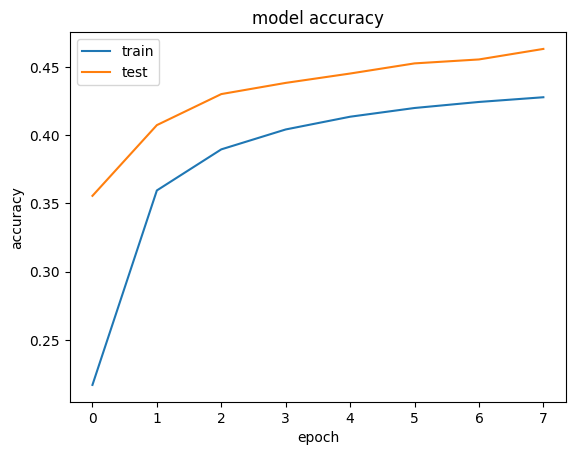

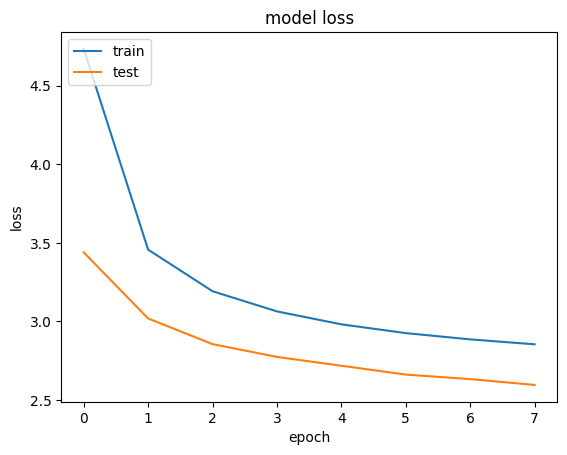

In [32]:
# Plot the changes in accuracy and loss for each epoch of the pretraining_model

print(pretrain_model_history.history.keys())
# summarize history for accuracy
plt.plot(pretrain_model_history.history['sparse_categorical_accuracy'])
plt.plot(pretrain_model_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(pretrain_model_history.history['loss'])
plt.plot(pretrain_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
# Get the weights for each layer

for lay in encoder_model.layers:
    print("Layer Name:", lay.name)
    print("weights:", len(lay.weights))
    print("trainable_weights:", len(lay.trainable_weights))
    print("Layer Weights:", lay.get_weights())
    print("*************************************************************************")

Layer Name: input_2
weights: 0
trainable_weights: 0
Layer Weights: []
*************************************************************************
Layer Name: token_and_position_embedding
weights: 2
trainable_weights: 2
Layer Weights: [array([[ 0.09041285, -0.04443691, -0.02360783, ..., -0.0961362 ,
        -0.4883083 , -0.14752206],
       [ 0.07366838,  0.05689593,  0.0254441 , ..., -0.01253184,
         0.09399934,  0.20078392],
       [-0.03240299,  0.01550581,  0.08673428, ..., -0.06965803,
         0.15651615,  0.11486798],
       ...,
       [-0.11378352,  0.03615182, -0.00120804, ..., -0.03474238,
        -0.01356508,  0.1042828 ],
       [-0.04490574,  0.01361303,  0.06111521, ...,  0.01217841,
         0.11697862,  0.04049196],
       [ 0.00921106,  0.04146209,  0.01498862, ..., -0.13573496,
         0.2618688 ,  0.12474287]], dtype=float32), array([[ 0.04355296, -0.0213163 , -0.03377971, ...,  0.05571266,
         0.03142761, -0.12380518],
       [ 0.07416366,  0.00500605, -0.0

In [34]:
# Save this base model for further finetuning.

encoder_model.save("encoder_model")

INFO:tensorflow:Assets written to: encoder_model/assets


INFO:tensorflow:Assets written to: encoder_model/assets


In [35]:
encoder_model.get_config()

{'name': 'model_1',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'registered_name': None,
   'name': 'input_2',
   'inbound_nodes': []},
  {'module': 'keras_nlp.src.layers.modeling.token_and_position_embedding',
   'class_name': 'TokenAndPositionEmbedding',
   'config': {'name': 'token_and_position_embedding',
    'trainable': True,
    'dtype': {'module': 'keras.mixed_precision',
     'class_name': 'Policy',
     'config': {'name': 'mixed_float16'},
     'registered_name': None},
    'vocabulary_size': 30522,
    'sequence_length': 128,
    'embedding_dim': 256,
    'embeddings_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'mask_zero': False},
   'registered_name': 'keras_nlp>TokenAndPositionEmbedding',

# Fine Tuning

After pretraining, we can now fine-tune the model on the SST-2 dataset.  We will leverage the ability of the encorder we built
to predict on words in context to boose our performance on the downstream task

## Preprocess Data for Classification

In [36]:
# For fine-tuning, the input sentenses only need to be tokenized 

def preprocess(sentences, labels):
    return tokenizer(sentences), labels

# We use prefetch() to pre-compute preprocessed batches on the fly on our CPU.
finetune_ds = sst_train_ds.map(preprocess, 
                               num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

finetune_val_ds = sst_val_ds.map(preprocess, 
                                 num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Preview a single input example.
# Before tokenization:
print(sst_val_ds.take(1).get_single_element())
print('**********************************************************************************')
# After tokenization:
print(finetune_val_ds.take(1).get_single_element())

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"it 's a charming and often affecting journey . ",
       b'unflinchingly bleak and desperate ',
       b'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ',
       b"the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ",
       b"it 's slow -- very , very slow . ",
       b'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ',
       b'a sometimes tedious film . ',
       b"or doing last year 's taxes with your ex-wife . ",
       b"you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . ",
       b"in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . ",
       b'the mesmerizing performances of the leads k

## Fine-tune the Transformer

To go from our encoded token output to a classification prediction, we need to attach another "head" to our Transformer model. We pool the encoded tokens together, and use a single dense layer to make a prediction.

In [37]:
# Reload the encoder model from disk so we can restart fine-tuning from scratch.
encoder_model = keras.models.load_model("encoder_model", compile=False)

# Take as input the tokenized input.
inputs = keras.Input(shape=(SEQ_LENGTH,), dtype=tf.int32)

# Encode and pool the tokens.
encoded_tokens = encoder_model(inputs)
pooled_tokens = keras.layers.GlobalAveragePooling1D()(encoded_tokens)

# Predict an output label.
outputs = keras.layers.Dense(1, activation="sigmoid")(pooled_tokens)

# 

# Define and compile our finetuning model.
finetuning_model = keras.Model(inputs, outputs)
finetuning_model.compile(loss="binary_crossentropy",
                         optimizer=keras.optimizers.experimental.AdamW(FINETUNING_LEARNING_RATE),
                         metrics=["accuracy"],)

# Finetune the model for the SST-2 task.
finetune_model_history = finetuning_model.fit(finetune_ds,
                                              validation_data=finetune_val_ds,
                                              epochs=FINETUNING_EPOCHS,)

Epoch 1/3
   2105/Unknown - 70s 31ms/step - loss: 0.4123 - accuracy: 0.8056

2023-10-22 12:28:07.849954: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9682359590440313262


2105/2105 [==============================] - 71s 31ms/step - loss: 0.4123 - accuracy: 0.8056 - val_loss: 0.4400 - val_accuracy: 0.8005
Epoch 2/3
   6/2105 [..............................] - ETA: 49s - loss: 0.3489 - accuracy: 0.8542

2023-10-22 12:28:08.327302: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4920476582337114239
2023-10-22 12:28:08.327330: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17376036532042343389
2023-10-22 12:28:08.327354: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4807478671261858342


2105/2105 [==============================] - 51s 24ms/step - loss: 0.2633 - accuracy: 0.8913 - val_loss: 0.4103 - val_accuracy: 0.8245
Epoch 3/3
2105/2105 [==============================] - 51s 24ms/step - loss: 0.1988 - accuracy: 0.9220 - val_loss: 0.4771 - val_accuracy: 0.8234


In [38]:
finetuning_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 model_1 (Functional)        (None, 128, 256)          9428224   
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9428481 (35.97 MB)
Trainable params: 9428481 (35.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
finetuning_model.get_config()

{'name': 'model_3',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'input_5'},
   'registered_name': None,
   'name': 'input_5',
   'inbound_nodes': []},
  {'module': 'keras.src.engine.functional',
   'class_name': 'Functional',
   'config': {'name': 'model_1',
    'trainable': True,
    'layers': [{'module': 'keras.layers',
      'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 128),
       'dtype': 'int32',
       'sparse': False,
       'ragged': False,
       'name': 'input_2'},
      'registered_name': None,
      'name': 'input_2',
      'inbound_nodes': []},
     {'module': 'keras_nlp.src.layers.modeling.token_and_position_embedding',
      'class_name': 'TokenAndPositionEmbedding',
      'config': {'name': 'token_and_position_embedding',
       'trainable': True,
       'dtype': {'module': 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


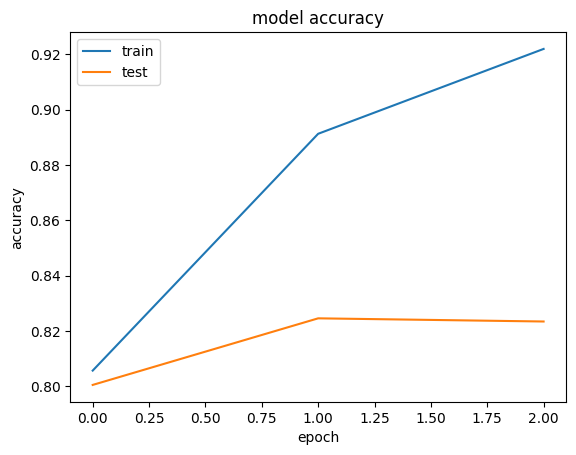

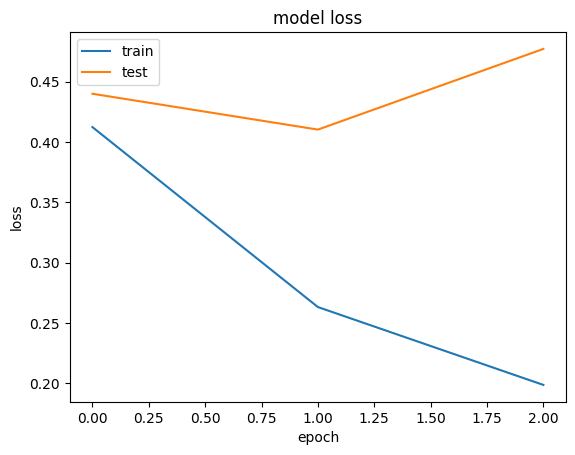

In [40]:
print(finetune_model_history.history.keys())
# summarize history for accuracy
plt.plot(finetune_model_history.history['accuracy'])
plt.plot(finetune_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(finetune_model_history.history['loss'])
plt.plot(finetune_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Get the weights for each layer

for lay in finetuning_model.layers:
    print("Layer Name:", lay.name)
    print("weights:", len(lay.weights))
    print("trainable_weights:", len(lay.trainable_weights))
    print("Layer Weights:", lay.get_weights())
    print("*************************************************************************")

Layer Name: input_5
weights: 0
trainable_weights: 0
Layer Weights: []
*************************************************************************
Layer Name: model_1
weights: 52
trainable_weights: 52
Layer Weights: [array([[ 0.0894656 , -0.04168599, -0.02444642, ..., -0.10006814,
        -0.4914366 , -0.1515134 ],
       [ 0.07357433,  0.05682538,  0.02540883, ..., -0.01251421,
         0.09385826,  0.20050175],
       [-0.03235596,  0.01548818,  0.08664022, ..., -0.06956398,
         0.15632804,  0.11472689],
       ...,
       [-0.11364244,  0.03610479, -0.00120657, ..., -0.03469535,
        -0.01354745,  0.10414171],
       [-0.04485871,  0.0135954 ,  0.06104467, ...,  0.01216078,
         0.11683753,  0.04044494],
       [ 0.0091993 ,  0.04141506,  0.01497098, ..., -0.13554685,
         0.26149258,  0.12460178]], dtype=float32), array([[ 0.03830998, -0.02101765, -0.03115197, ...,  0.05461784,
         0.02993759, -0.11868154],
       [ 0.06700202,  0.0080929 , -0.04193427, ...,  0.05

## Save a Model Accepting Raw Text

In [42]:
# Add our tokenization into our final model.
inputs = keras.Input(shape=(), dtype=tf.string)
tokens = tokenizer(inputs)
outputs = finetuning_model(tokens)
final_model = keras.Model(inputs, outputs)
final_model.save("final_model")

# This model can predict directly on raw text.
restored_model = keras.models.load_model("final_model", compile=False)


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f3a920>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f3a920>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7d5d0>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7d5d0>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7e590>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7e590>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7f520>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7f520>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc04f0>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc04f0>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc1480>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc1480>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc2410>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc2410>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc33a0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc33a0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e0c3d0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e0c3d0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e60d30>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e60d30>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e61d50>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e61d50>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e62ce0>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e62ce0>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e63cd0>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e63cd0>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea4ca0>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea4ca0>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea5c30>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea5c30>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea6bc0>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea6bc0>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea7b50>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea7b50>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfcb20>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfcb20>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfdab0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfdab0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfea40>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfea40>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cffa30>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cffa30>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d903d0>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d903d0>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d913f0>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d913f0>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d92380>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d92380>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d93370>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d93370>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd8340>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd8340>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd92d0>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd92d0>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dda260>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dda260>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ddb1f0>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ddb1f0>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c341c0>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c341c0>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c35150>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c35150>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c360e0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c360e0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c370d0>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c370d0>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c83a30>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c83a30>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc8a90>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc8a90>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc9a20>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc9a20>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccaa10>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccaa10>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccb9a0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccb9a0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54b1c9d0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54b1c9d0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b1d20>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b1d20>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b2e30>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b2e30>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b3d30>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b3d30>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54760c40>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54760c40>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54761b10>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54761b10>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547629e0>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547629e0>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547638b0>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547638b0>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b47c0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b47c0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b56c0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b56c0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b6a10>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b6a10>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b7940>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b7940>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54600880>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54600880>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54601780>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54601780>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54602680>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54602680>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54603550>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54603550>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464c460>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464c460>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464d330>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464d330>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464e200>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464e200>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464f0d0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464f0d0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464ffa0>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464ffa0>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a0ee0>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a0ee0>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a2230>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a2230>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a3160>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a3160>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0070>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0070>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0fa0>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0fa0>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f1ea0>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f1ea0>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f2d70>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f2d70>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f3c40>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f3c40>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54540b50>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54540b50>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54541a20>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54541a20>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545428f0>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545428f0>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545437c0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545437c0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54590700>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54590700>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54591a50>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54591a50>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54592980>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54592980>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54593880>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54593880>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e47c0>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e47c0>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e56c0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e56c0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e65c0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e65c0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f3a920>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f3a920>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7d5d0>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7d5d0>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7e590>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7e590>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7f520>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54f7f520>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc04f0>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc04f0>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc1480>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc1480>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc2410>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc2410>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc33a0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54fc33a0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e0c3d0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e0c3d0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e60d30>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e60d30>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e61d50>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e61d50>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e62ce0>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e62ce0>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e63cd0>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54e63cd0>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea4ca0>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea4ca0>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea5c30>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea5c30>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea6bc0>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea6bc0>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea7b50>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ea7b50>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfcb20>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfcb20>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfdab0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfdab0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfea40>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cfea40>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cffa30>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cffa30>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d903d0>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d903d0>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d913f0>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d913f0>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d92380>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d92380>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d93370>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54d93370>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd8340>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd8340>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd92d0>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dd92d0>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dda260>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54dda260>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ddb1f0>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ddb1f0>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c341c0>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c341c0>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c35150>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c35150>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c360e0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c360e0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c370d0>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c370d0>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c83a30>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54c83a30>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc8a90>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc8a90>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc9a20>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54cc9a20>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccaa10>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccaa10>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccb9a0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54ccb9a0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54b1c9d0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54b1c9d0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b1d20>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b1d20>, 140232230627456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b2e30>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b2e30>, 140232901340976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b3d30>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a548b3d30>, 140232901329776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54760c40>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54760c40>, 140232901330160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54761b10>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54761b10>, 140232898605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547629e0>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547629e0>, 140232898600880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547638b0>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547638b0>, 140232902113200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b47c0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b47c0>, 140232902111024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b56c0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b56c0>, 140232900381104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b6a10>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b6a10>, 140232231940272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b7940>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a547b7940>, 140232233484720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54600880>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54600880>, 140232233498480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54601780>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54601780>, 140232901345136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54602680>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54602680>, 140232230459312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54603550>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54603550>, 140232230468848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464c460>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464c460>, 140232230459568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464d330>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464d330>, 140232230466032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464e200>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464e200>, 140232230457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464f0d0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464f0d0>, 140232230454256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464ffa0>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a5464ffa0>, 140232899460592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a0ee0>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a0ee0>, 140232232338288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a2230>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a2230>, 140232901061936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a3160>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546a3160>, 140232901065072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0070>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0070>, 140232901058864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0fa0>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f0fa0>, 140232901063920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f1ea0>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f1ea0>, 140232233659056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f2d70>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f2d70>, 140232233655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f3c40>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a546f3c40>, 140232233392688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54540b50>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54540b50>, 140232233391792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54541a20>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54541a20>, 140232231398640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545428f0>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545428f0>, 140232231388720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545437c0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 64, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545437c0>, 140232231402032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54590700>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54590700>, 140232231395824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54591a50>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54591a50>, 140232900542128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54592980>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54592980>, 140232229348976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54593880>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a54593880>, 140232229347184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e47c0>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e47c0>, 140232229351728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e56c0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e56c0>, 140246701299376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e65c0>, 140246701305136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8a545e65c0>, 140246701305136), {}).


INFO:tensorflow:Assets written to: final_model/assets


INFO:tensorflow:Assets written to: final_model/assets


In [43]:
restored_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 word_piece_tokenizer (Word  (None, 128)               0         
 PieceTokenizer)                                                 
                                                                 
 model_3 (Functional)        (None, 1)                 9428481   
                                                                 
Total params: 9428481 (35.97 MB)
Trainable params: 9428481 (35.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This will allow us to validate whether a phrase portrays a positive or negative sentiment.  A score of 0 has no positivity at all while a score of 1 would be the highest possible rating in positivity.  The examples below highlight this.

In [44]:
#inference_data = tf.constant(["Terrible, no good, trash.", "So great; I loved it!"])
inference_data = tf.constant(["Terrible, no good, trash."])
positivity_rate = restored_model(inference_data)
print(positivity_rate)

tf.Tensor([[0.0531]], shape=(1, 1), dtype=float16)


In [45]:
print(positivity_rate.ndim)

2


In [46]:
positivity_rate = tf.cast(positivity_rate[0][0],tf.float32)
print("Positivity Rate: ",positivity_rate)

if positivity_rate < .45:
    print ("The sentiment of the sentence is negative")
elif positivity_rate >=.45 and positivity_rate < .55 :
    print ("The sentiment of the sentence is neutral")
else:
    print ("The sentiment of the sentence is positive")

Positivity Rate:  tf.Tensor(0.053100586, shape=(), dtype=float32)
The sentiment of the sentence is negative


In [105]:
# Writing a function to analyse a sentence passed as a param:

def print_results(sentence):
    inference_data = tf.constant([sentence])
    positivity_rate = tf.cast(restored_model(inference_data)[0][0],tf.float32)

    if positivity_rate < .4:
        print ("Positivity Rate: ",positivity_rate,"-- The sentiment of \"" + sentence + "\" is negative")
    elif positivity_rate >=.4 and positivity_rate < .6 :
        print ("Positivity Rate: ",positivity_rate,"-- The sentiment of \"" + sentence + "\" is neutral")
    else:
        print ("Positivity Rate: ",positivity_rate,"-- The sentiment of \"" + sentence + "\" is positive")

In [106]:
print_results("So great; I loved it!")

Positivity Rate:  tf.Tensor(1.0, shape=(), dtype=float32) -- The sentiment of "So great; I loved it!" is positive


In [107]:
print_results("This is average!")

Positivity Rate:  tf.Tensor(0.8051758, shape=(), dtype=float32) -- The sentiment of "This is average!" is positive


In [108]:
print_results("This is average")

Positivity Rate:  tf.Tensor(0.7158203, shape=(), dtype=float32) -- The sentiment of "This is average" is positive


In [109]:
print_results("This is a nightmare!")

Positivity Rate:  tf.Tensor(0.71777344, shape=(), dtype=float32) -- The sentiment of "This is a nightmare!" is positive


In [110]:
print_results("I don't know")

Positivity Rate:  tf.Tensor(0.26464844, shape=(), dtype=float32) -- The sentiment of "I don't know" is negative


In [111]:
print_results("This is a dream!")

Positivity Rate:  tf.Tensor(0.99902344, shape=(), dtype=float32) -- The sentiment of "This is a dream!" is positive


In [112]:
print_results("I don't care")

Positivity Rate:  tf.Tensor(0.14501953, shape=(), dtype=float32) -- The sentiment of "I don't care" is negative


In [113]:
print_results("I love my dog")

Positivity Rate:  tf.Tensor(0.98828125, shape=(), dtype=float32) -- The sentiment of "I love my dog" is positive


In [114]:
print_results("I hate horror movies")

Positivity Rate:  tf.Tensor(0.032226562, shape=(), dtype=float32) -- The sentiment of "I hate horror movies" is negative
